# Measles vaccination - deSolve (28/07/25)

## Model compartments
![alt text](measles_seir.png) <br/>
$b$: avg birth rate per day <br/>
$c$: vaccine coverage <br/>
$\lambda$: force of infection <br/>
$f$: avg rate of being infectious <br/>
$r$: avg rate of recovery <br/>
$\mu$: avg death rate per day


## Difference equations
$$
S_{t+1}=((1-c) * b * N) + S_t - (\lambda_t * S_t) - (\mu * S_t)
$$
$$
E_{t+1}=E_t+(\lambda_t*S_t)-(f*E_t)-(\mu*E_t)
$$
$$
I_{t+1}=I_t+(f*E_t)-(r*I_t)-(\mu*I_t)
$$
$$
R_{t+1}=(c*b*N)+R_t+(r*I_t)-(\mu*R_t)
$$

## Differential equations
$$
\frac{dS}{dt}=((1-c)*b*N)-(\lambda_t*S_t)-(\mu*S_t)
$$
$$
\frac{dE}{dt}=(\lambda_t*S_t)-(f*E_t)-(\mu*E_t)
$$
$$
\frac{dI}{dt}=(f*E_t)-(r*I_t)-(\mu*I_t)
$$
$$
\frac{dR}{dt}=(c*b*N)+(r*I_t)-(\mu*R_t)
$$

In [1]:
library(deSolve)
library(reshape2)
library(ggplot2)

In [2]:
# To define model inputs
N <- 1e5
ecr <- 1.86 # Effective contact rate
beta <- ecr / N
dur_lat <- 8 # Avg duration of latency (days)
f <- 1 / dur_lat # Avg rate of being infectious
dur_inf <- 7 # Avg duration of infectiousness (days)
r <- 1 / dur_inf # Avg rate of recovery
life_exp <- 70 # Avg life expectancy (years)
mu <- 1 / life_exp / 365 # Avg death rate per day
b <- 1 / life_exp / 365 # Avg birth rate per day, assuming mu=b
c <- 0.1 # Vaccine coverage
parms <- c(beta = beta, f = f, r = r, mu = mu, c = c, b = b)
ini_state_values <- c(
    S = N - 1 - c * N,
    E = 0,
    I = 1,
    R = c * N,
    C = 0,
    V = c * N)
times <- seq(from = 0, to = 200, by = 1)

# To define SEIR model
seir_model <- function(time, state, parameters){
    with(as.list(c(state, parameters)),{
        N <- S + E + I + R
        lambda <- beta * I
        cum_cases <- lambda * S
        cum_vacc <- c * b * N
        dS <- ((1 - c) * b * N) - lambda * S - mu * S
        dE <- lambda * S - f * E - mu * E
        dI <- f * E - r * I - mu * I
        dR <- (c * b * N) + r * I - mu * R
        dC <- cum_cases # To calculate cumulative cases
        dV <- cum_vacc # To calculate cumulative vaccinations
        return(list(c(dS, dE, dI, dR, dC, dV)))
    })
}
df <- as.data.frame(ode(
    y = ini_state_values,
    times = times,
    func = seir_model,
    parms = parms))

# To calculate daily cases
df$daily_cases <- c(0, diff(df[["C"]]))
df$daily_vacc <- c(c * N, diff(df[["V"]]))
 
# To preview dataframe
head(df, 10)

,time,S,E,I,R,C,V,daily_cases,daily_vacc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,89999.00,0.000000,1.0000000,10000.00,0.000000,10000.00,0.000000,1.000000e+04
2,1,89997.39,1.515697,0.9596823,10000.14,1.613111,10000.39,1.613111,3.913894e-01
3,2,89995.69,2.933648,1.0925381,10000.28,3.308755,10000.78,1.695644,3.913894e-01
4,3,89993.64,4.518681,1.3805200,10000.46,5.356746,10001.17,2.047991,3.913894e-01
5,4,89990.98,6.501839,1.8362832,10000.68,8.023543,10001.57,2.666797,3.913894e-01
6,5,89987.38,9.127724,2.4981181,10000.99,11.618475,10001.96,3.594931,3.913894e-01
7,6,89982.47,12.692983,3.4304522,10001.41,16.536363,10002.35,4.917889,3.913894e-01
8,7,89975.70,17.584590,4.7286821,10001.99,23.304680,10002.74,6.768317,3.913894e-01
9,8,89966.36,24.324449,6.5281382,10002.79,32.642131,10003.13,9.337450,3.913894e-01


In [ ]:
# To define CEA model inputs
cCase <- 20 # Avg cost per case of measles
cVacc <- 5 # Avg cost per vaccination
duCase <- 0.2 # Avg QALY loss per case of measles
disc_rate <- 0.03 # Discount rate per year

# To calculate costs & QALY losses
df$cost_cases <- df[["daily_cases"]] * cCase
df$cost_vacc <- df[["daily_vacc"]] * cVacc
df$qaly_lost <- df[["daily_cases"]] * duCase
df$disc_factor <- 1 / (1 + disc_rate)^(df[["time"]] / 365)
df$disc_cost_cases <- df[["cost_cases"]] * df[["disc_factor"]]
df$disc_cost_vacc <- df[["cost_vacc"]] * df[["disc_factor"]]
df$disc_qaly_lost <- df[["qaly_lost"]] * df[["disc_factor"]]

# To preview dataframe
head(df, 10)

,time,S,E,I,R,C,V,daily_cases,daily_vacc,cost_cases,cost_vacc,qaly_lost,disc_factor,disc_cost_cases,disc_cost_vacc,disc_qaly_lost
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,89999.00,0.000000,1.0000000,10000.00,0.000000,10000.00,0.000000,1.000000e+04,0.00000,50000.000000,0.0000000,1.0000000,0.00000,50000.000000,0.0000000
2,1,89997.39,1.515697,0.9596823,10000.14,1.613111,10000.39,1.613111,3.913894e-01,32.26221,1.956947,0.3226221,0.9999190,32.25960,1.956789,0.3225960
3,2,89995.69,2.933648,1.0925381,10000.28,3.308755,10000.78,1.695644,3.913894e-01,33.91288,1.956947,0.3391288,0.9998380,33.90739,1.956630,0.3390739
4,3,89993.64,4.518681,1.3805200,10000.46,5.356746,10001.17,2.047991,3.913894e-01,40.95982,1.956947,0.4095982,0.9997571,40.94987,1.956472,0.4094987
5,4,89990.98,6.501839,1.8362832,10000.68,8.023543,10001.57,2.666797,3.913894e-01,53.33595,1.956947,0.5333595,0.9996761,53.31867,1.956313,0.5331867
6,5,89987.38,9.127724,2.4981181,10000.99,11.618475,10001.96,3.594931,3.913894e-01,71.89863,1.956947,0.7189863,0.9995952,71.86952,1.956155,0.7186952
7,6,89982.47,12.692983,3.4304522,10001.41,16.536363,10002.35,4.917889,3.913894e-01,98.35777,1.956947,0.9835777,0.9995142,98.30999,1.955997,0.9830999
8,7,89975.70,17.584590,4.7286821,10001.99,23.304680,10002.74,6.768317,3.913894e-01,135.36634,1.956947,1.3536634,0.9994333,135.28962,1.955838,1.3528962
9,8,89966.36,24.324449,6.5281382,10002.79,32.642131,10003.13,9.337450,3.913894e-01,186.74901,1.956947,1.8674901,0.9993523,186.62806,1.955680,1.8662806


In [4]:
# To sum costs & QALY losses
sum_df <- df[, 8:16] # To select columns 8 to 16
print(colSums(sum_df)) # To sum columns

    daily_cases      daily_vacc      cost_cases       cost_vacc       qaly_lost 
      90128.477       10078.278     1802569.536       50391.389       18025.695 
    disc_factor disc_cost_cases  disc_cost_vacc  disc_qaly_lost 
        199.381     1797898.856       50388.221       17978.989 


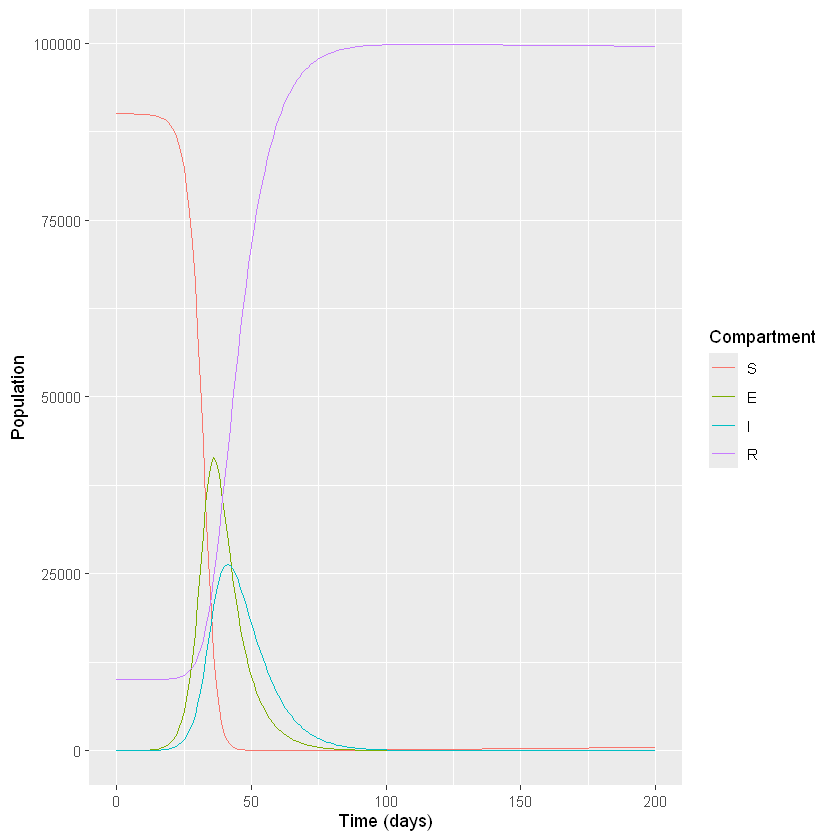

In [5]:
# To plot model output
sel_df <- df[, 1:5] # To select columns 1 to 5
sel_df_long <- melt(as.data.frame(sel_df), id="time") # To convert to long form
plot <- ggplot(
    data = sel_df_long,
    aes(x = time, y = value, color = variable, group = variable)) +
    geom_line() +
    labs(
        x = "Time (days)",
        y = "Population",
        color = "Compartment")
print(plot)